In [4]:
# Step 0.1: Install Prophet (if not already installed in your Colab environment)
!pip install prophet
!pip install plotly # Usually pre-installed, but good to ensure

In [5]:
# Step 0.2: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Set some display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
plt.style.use('seaborn-v0_8-whitegrid') # Using a seaborn style

In [6]:
# Step 1.1: Generate Synthetic Sales Data
np.random.seed(42) # for reproducibility

# Date range: 4 years of daily data
dates = pd.date_range(start='2020-01-01', end='2023-12-31', freq='D')
n_dates = len(dates)

product_lines = ['Electronics', 'Clothing', 'Home Goods']
data_list = []

for product in product_lines:
    # Base sales differ for each product
    if product == 'Electronics':
        base_sales = 100
        trend_factor = 0.05 # Stronger positive trend
        seasonal_amplitude = 30
        noise_level = 20
    elif product == 'Clothing':
        base_sales = 70
        trend_factor = 0.02
        seasonal_amplitude = 40 # Stronger seasonality
        noise_level = 15
    else: # Home Goods
        base_sales = 50
        trend_factor = -0.01 # Slight negative trend initially, then flattens
        seasonal_amplitude = 20
        noise_level = 10

    # Generate trend
    trend = np.linspace(0, trend_factor * n_dates, n_dates)
    if product == 'Home Goods': # Make trend for home goods a bit more complex
        trend = trend - 0.00003 * (np.arange(n_dates) - n_dates/2)**2


    # Generate seasonality (yearly cycle, peaks around Nov-Dec and a smaller one mid-year)
    day_of_year = np.array([d.dayofyear for d in dates])
    seasonality = seasonal_amplitude * (
        np.sin(2 * np.pi * (day_of_year - 150) / 365.25) +  # Mid-year dip/peak
        0.7 * np.sin(2 * np.pi * (day_of_year - 330) / 365.25 + np.pi/2) # Stronger end-of-year peak
    )

    # Generate noise
    noise = np.random.normal(0, noise_level, n_dates)

    # Calculate sales
    sales = base_sales + trend + seasonality + noise
    sales = np.maximum(sales, 10) # Ensure sales are not negative or too low

    # Append to list
    for i in range(n_dates):
        data_list.append({'Date': dates[i], 'ProductLine': product, 'Sales': sales[i]})

df_sales = pd.DataFrame(data_list)

print("Generated Sales Data Sample:")
print(df_sales.head())
print(f"\nData Shape: {df_sales.shape}")

Generated Sales Data Sample:
        Date  ProductLine       Sales
0 2020-01-01  Electronics  110.580504
1 2020-01-02  Electronics   97.287834
2 2020-01-03  Electronics  112.413789
3 2020-01-04  Electronics  129.327702
4 2020-01-05  Electronics   93.591504

Data Shape: (4383, 3)


In [7]:
# Step 2.1: Basic Data Inspection
print("\n--- Data Info ---")
df_sales.info()

print("\n--- Descriptive Statistics ---")
print(df_sales.describe())

print("\n--- Missing Values ---")
print(df_sales.isnull().sum())

# Step 2.2: Convert 'Date' to datetime (already done by date_range, but good practice if loading from CSV)
df_sales['Date'] = pd.to_datetime(df_sales['Date'])

# Step 2.3: Set 'Date' as index (useful for some time series operations)
# We will create a copy for operations that modify the index, keeping the original df_sales for others
df_sales_indexed = df_sales.set_index('Date').copy()

# Step 2.4: Feature Engineering - Extract time components
df_sales['Year'] = df_sales['Date'].dt.year
df_sales['Month'] = df_sales['Date'].dt.month
df_sales['Day'] = df_sales['Date'].dt.day
df_sales['DayOfWeek'] = df_sales['Date'].dt.dayofweek # Monday=0, Sunday=6
df_sales['Quarter'] = df_sales['Date'].dt.quarter
df_sales['MonthName'] = df_sales['Date'].dt.strftime('%B') # Month name

print("\n--- Data with new features ---")
print(df_sales.head())


--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4383 entries, 0 to 4382
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         4383 non-null   datetime64[ns]
 1   ProductLine  4383 non-null   object        
 2   Sales        4383 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 102.9+ KB

--- Descriptive Statistics ---
                      Date        Sales
count                 4383  4383.000000
mean   2021-12-31 00:00:00    86.706427
min    2020-01-01 00:00:00    10.000000
25%    2020-12-31 00:00:00    41.296851
50%    2021-12-31 00:00:00    75.853990
75%    2022-12-31 00:00:00   127.550668
max    2023-12-31 00:00:00   249.007317
std                    NaN    54.086611

--- Missing Values ---
Date           0
ProductLine    0
Sales          0
dtype: int64

--- Data with new features ---
        Date  ProductLine       Sales  Year  

<ipython-input-8-f17813cf3e53>:9: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



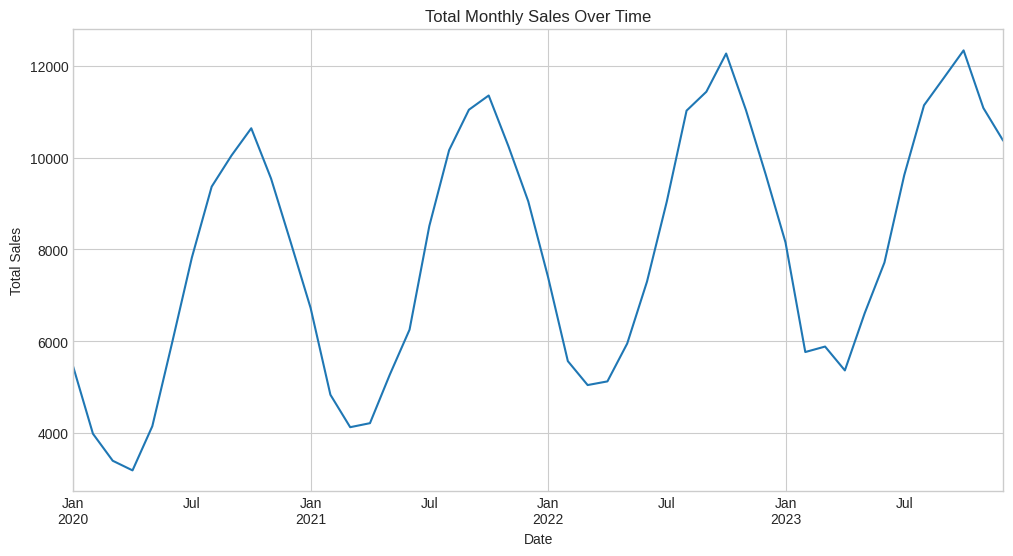

In [8]:
# Step 3.1.1: Aggregate total daily sales
total_daily_sales = df_sales.groupby('Date')['Sales'].sum().reset_index()

# Plotting total daily sales trend using Plotly
fig_total_sales = px.line(total_daily_sales, x='Date', y='Sales', title='Total Daily Sales Over Time')
fig_total_sales.show()

# Plotting total monthly sales trend (resampled)
total_monthly_sales = df_sales_indexed.groupby('ProductLine')['Sales'].resample('M').sum()
total_monthly_sales_agg = total_monthly_sales.groupby(level=1).sum() # Sum across products for each month

plt.figure(figsize=(12, 6))
total_monthly_sales_agg.plot()
plt.title('Total Monthly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.show()

<ipython-input-9-aff5f197fceb>:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




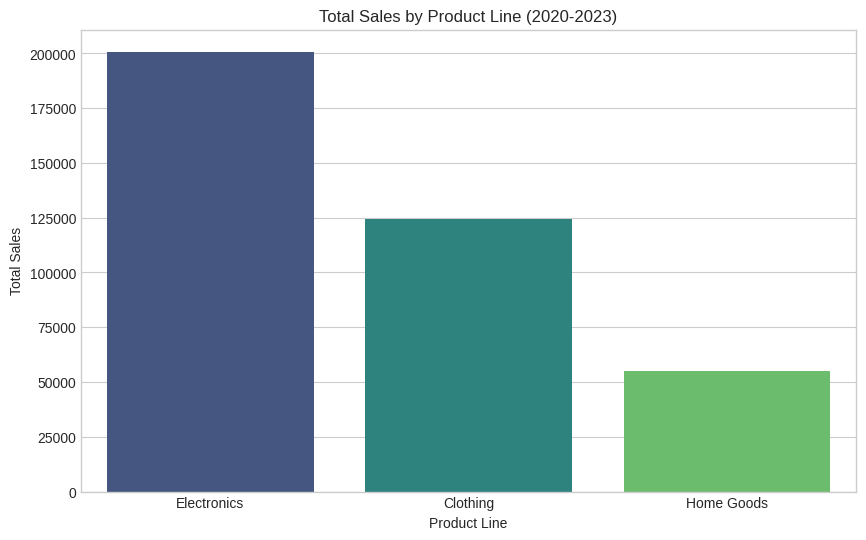

In [9]:
# Step 3.2.1: Plotting daily sales for each product line using Plotly
fig_product_sales = px.line(df_sales, x='Date', y='Sales', color='ProductLine',
                            title='Daily Sales by Product Line Over Time')
fig_product_sales.show()

# Step 3.2.2: Total sales by product line (Bar Chart)
total_sales_per_product = df_sales.groupby('ProductLine')['Sales'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=total_sales_per_product.index, y=total_sales_per_product.values, palette='viridis')
plt.title('Total Sales by Product Line (2020-2023)')
plt.xlabel('Product Line')
plt.ylabel('Total Sales')
plt.show()

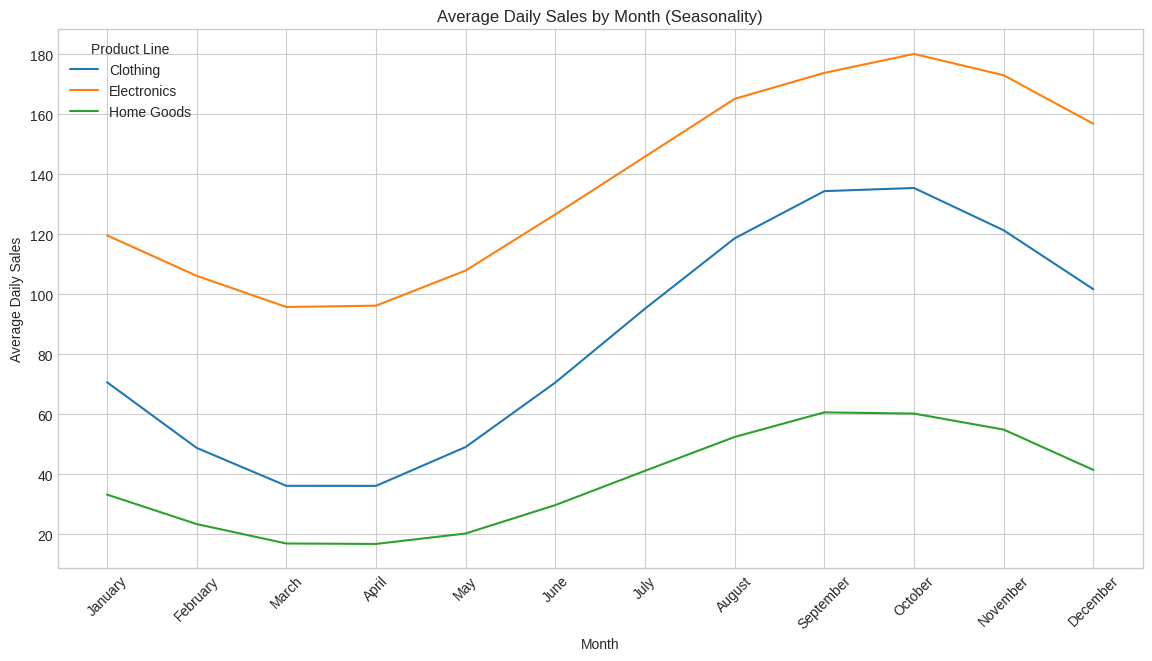

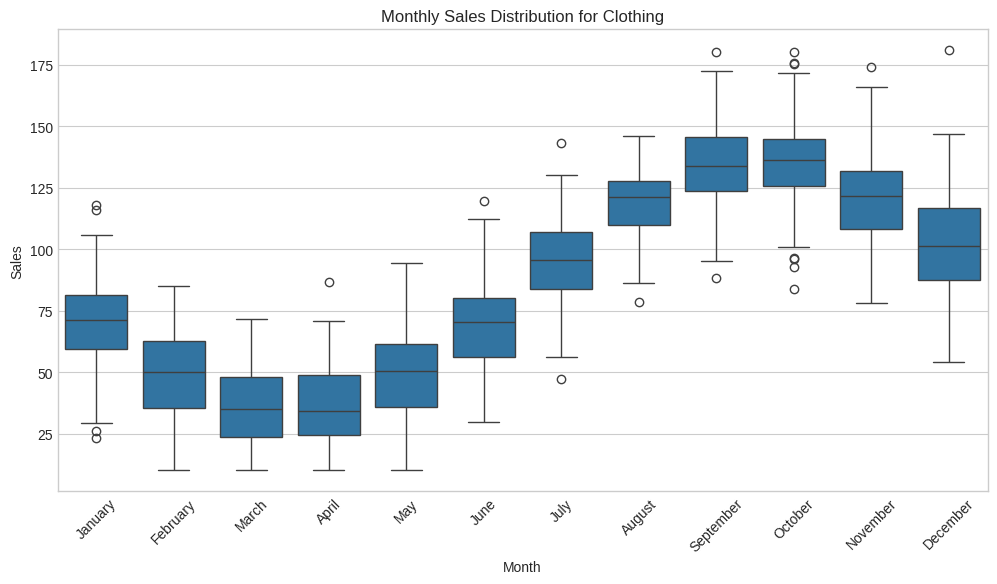

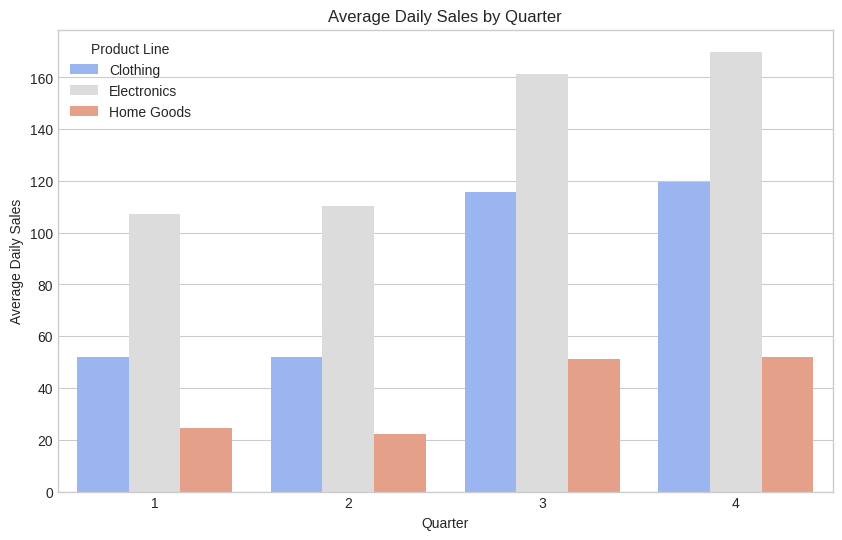

In [10]:
# Step 3.3.1: Average sales by month for each product line
avg_monthly_sales = df_sales.groupby(['ProductLine', 'MonthName', 'Month'])['Sales'].mean().reset_index()
avg_monthly_sales = avg_monthly_sales.sort_values('Month') # Sort by month number

plt.figure(figsize=(14, 7))
sns.lineplot(data=avg_monthly_sales, x='MonthName', y='Sales', hue='ProductLine', sort=False)
plt.title('Average Daily Sales by Month (Seasonality)')
plt.xlabel('Month')
plt.ylabel('Average Daily Sales')
plt.xticks(rotation=45)
plt.legend(title='Product Line')
plt.show()

# Step 3.3.2: Box plot of sales by month for a specific product (e.g., Clothing)
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_sales[df_sales['ProductLine'] == 'Clothing'], x='MonthName', y='Sales',
            order=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
plt.title('Monthly Sales Distribution for Clothing')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.show()

# Step 3.3.3: Sales by Quarter
avg_quarterly_sales = df_sales.groupby(['ProductLine', 'Quarter'])['Sales'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_quarterly_sales, x='Quarter', y='Sales', hue='ProductLine', palette='coolwarm')
plt.title('Average Daily Sales by Quarter')
plt.xlabel('Quarter')
plt.ylabel('Average Daily Sales')
plt.legend(title='Product Line')
plt.show()

<ipython-input-11-6d6110407a02>:3: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



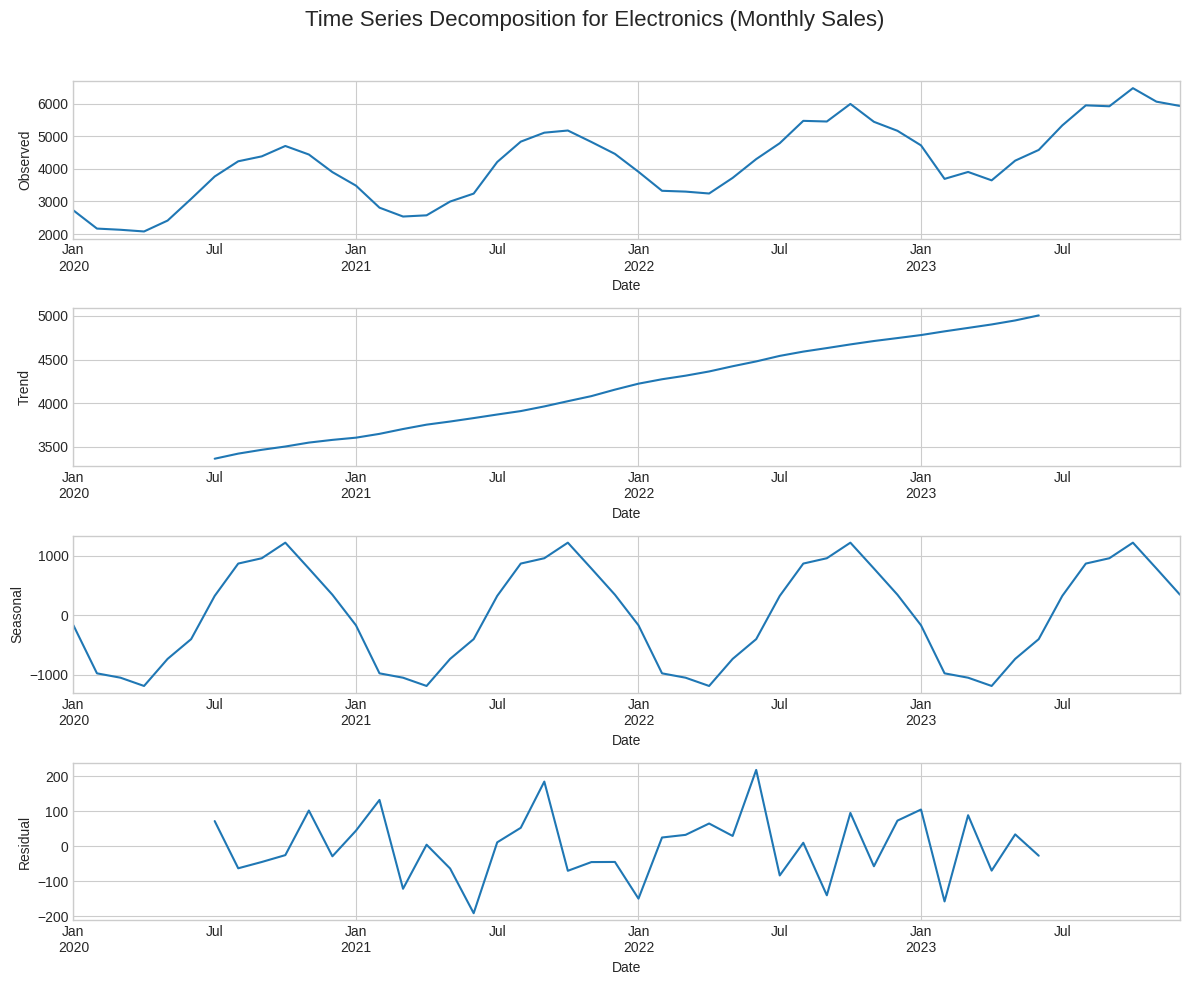

In [11]:
# Step 3.4.1: Decompose time series for 'Electronics'
# We need a series with a DatetimeIndex. Resample to monthly if daily is too noisy for clear decomposition plots.
electronics_sales_monthly = df_sales_indexed[df_sales_indexed['ProductLine'] == 'Electronics']['Sales'].resample('M').sum()

# Ensure at least 2 full periods for decomposition (e.g., 24 months for yearly seasonality)
if len(electronics_sales_monthly) >= 24:
    decomposition_electronics = seasonal_decompose(electronics_sales_monthly, model='additive', period=12) # period=12 for monthly data with yearly seasonality

    fig_decomposition = plt.figure(figsize=(12, 10))
    fig_decomposition.suptitle('Time Series Decomposition for Electronics (Monthly Sales)', fontsize=16)

    ax1 = fig_decomposition.add_subplot(411)
    decomposition_electronics.observed.plot(ax=ax1)
    ax1.set_ylabel('Observed')

    ax2 = fig_decomposition.add_subplot(412)
    decomposition_electronics.trend.plot(ax=ax2)
    ax2.set_ylabel('Trend')

    ax3 = fig_decomposition.add_subplot(413)
    decomposition_electronics.seasonal.plot(ax=ax3)
    ax3.set_ylabel('Seasonal')

    ax4 = fig_decomposition.add_subplot(414)
    decomposition_electronics.resid.plot(ax=ax4)
    ax4.set_ylabel('Residual')

    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for suptitle
    plt.show()
else:
    print("Not enough data points for seasonal decomposition with period 12 after resampling to monthly.")

In [12]:
# Step 4.0: Prepare data for forecasting - Electronics Monthly Sales
# electronics_sales_monthly was prepared in Step 3.4.1
# Ensure it's a Series with DatetimeIndex
product_to_forecast = 'Electronics'
ts_data = df_sales_indexed[df_sales_indexed['ProductLine'] == product_to_forecast]['Sales'].resample('M').sum()

print(f"\n--- Data for Forecasting ({product_to_forecast} Monthly Sales) ---")
print(ts_data.head())
print(f"Length of time series: {len(ts_data)}")

# Split data into training and testing (e.g., last 12 months for testing)
train_size = len(ts_data) - 12
train_data = ts_data.iloc[:train_size]
test_data = ts_data.iloc[train_size:]

print(f"\nTraining data size: {len(train_data)}")
print(f"Test data size: {len(test_data)}")


--- Data for Forecasting (Electronics Monthly Sales) ---
Date
2020-01-31    2725.251877
2020-02-29    2167.849377
2020-03-31    2131.085999
2020-04-30    2079.233009
2020-05-31    2413.169670
Freq: ME, Name: Sales, dtype: float64
Length of time series: 48

Training data size: 36
Test data size: 12


<ipython-input-12-e4479ff248c2>:5: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.




--- ARIMA Model Summary ---
                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   36
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -256.607
Date:                Mon, 26 May 2025   AIC                            519.213
Time:                        07:20:31   BIC                            523.879
Sample:                    01-31-2020   HQIC                           520.824
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6200      0.295      2.105      0.035       0.043       1.197
ma.L1         -0.0678      0.401     -0.169      0.866      -0.854       0.719
sigma2      1.305e+05  

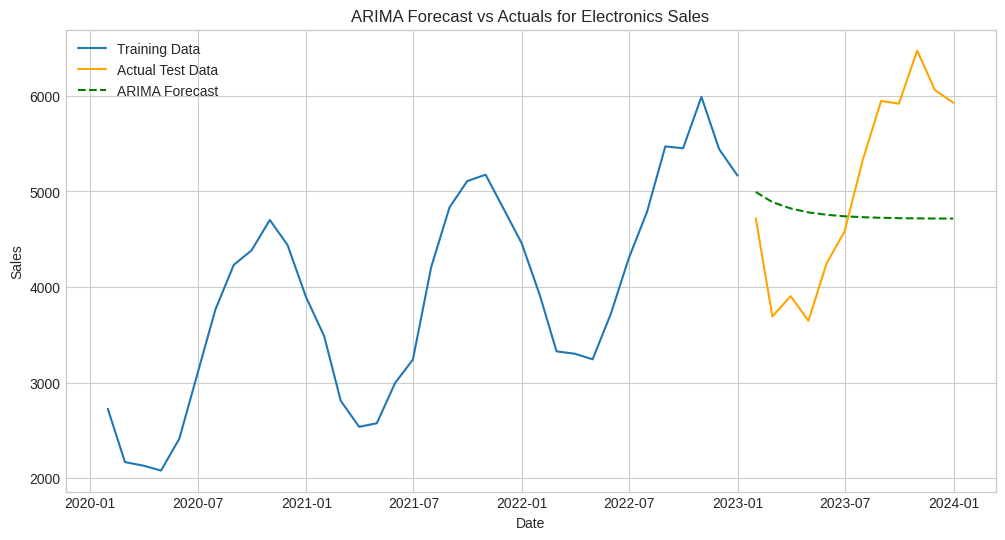

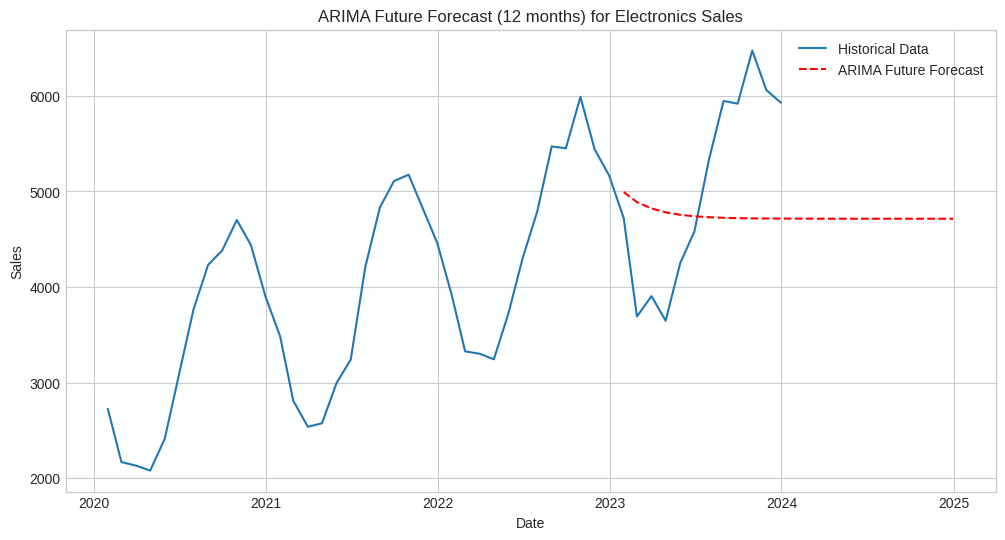

In [13]:
# Step 4.1.1: (Optional but good practice) Check for stationarity using ADF test
# For ARIMA, the series should be stationary. If not, differencing (d) is needed.
# result_adf = adfuller(train_data.dropna())
# print(f'\nADF Statistic for {product_to_forecast} (Train Data): {result_adf[0]}')
# print(f'p-value: {result_adf[1]}')
# If p-value > 0.05, series is likely non-stationary.

# Step 4.1.2: Fit ARIMA model
# Choosing (p,d,q) can be done via ACF/PACF plots or auto_arima.
# For simplicity, we'll pick a common order, e.g., (5,1,0) or (1,1,1).
# Let's try (p=1, d=1, q=1) for SARIMA-like behavior.
# If using simple ARIMA, you might need to difference data first if non-stationary.
# The ARIMA model in statsmodels can handle differencing internally with the 'd' parameter.

try:
    # For seasonal data, SARIMA (Seasonal ARIMA) is often better.
    # ARIMA(order=(p,d,q), seasonal_order=(P,D,Q,s))
    # For this example, let's use a simple ARIMA first, then mention SARIMA
    # We'll use a simple ARIMA order. For actual application, fine-tune (p,d,q)
    # or use SARIMAX for seasonal data.
    # order=(1,1,1) implies:
    #   d=1: difference data once to make it stationary
    #   p=1: use 1 lagged value for AR term
    #   q=1: use 1 lagged forecast error for MA term
    arima_model = ARIMA(train_data, order=(1, 1, 1)) # A common simple order
    arima_fit = arima_model.fit()
    print("\n--- ARIMA Model Summary ---")
    print(arima_fit.summary())

    # Step 4.1.3: Make predictions
    # Forecast for the length of the test set
    start_index = len(train_data)
    end_index = len(train_data) + len(test_data) - 1
    # Note: statsmodels predict() is for in-sample. forecast() is for out-of-sample.
    arima_pred = arima_fit.predict(start=start_index, end=end_index, dynamic=False)
    # For newer versions, forecast() is preferred:
    # arima_pred = arima_fit.forecast(steps=len(test_data))

    # Align index for plotting
    arima_pred.index = test_data.index

    # Step 4.1.4: Evaluate Model
    arima_mae = mean_absolute_error(test_data, arima_pred)
    arima_rmse = np.sqrt(mean_squared_error(test_data, arima_pred))
    print(f"\nARIMA Model Performance ({product_to_forecast}):")
    print(f"MAE: {arima_mae:.2f}")
    print(f"RMSE: {arima_rmse:.2f}")

    # Step 4.1.5: Plot ARIMA forecast vs actual
    plt.figure(figsize=(12, 6))
    plt.plot(train_data.index, train_data, label='Training Data')
    plt.plot(test_data.index, test_data, label='Actual Test Data', color='orange')
    plt.plot(arima_pred.index, arima_pred, label='ARIMA Forecast', color='green', linestyle='--')
    plt.title(f'ARIMA Forecast vs Actuals for {product_to_forecast} Sales')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()

    # Step 4.1.6: Forecast future sales (beyond test data)
    future_steps_arima = 12 # Forecast 12 months into the future
    arima_future_forecast = arima_fit.forecast(steps=len(test_data) + future_steps_arima)

    plt.figure(figsize=(12, 6))
    plt.plot(ts_data.index, ts_data, label='Historical Data')
    plt.plot(arima_future_forecast.index, arima_future_forecast, label='ARIMA Future Forecast', color='red', linestyle='--')
    plt.title(f'ARIMA Future Forecast (12 months) for {product_to_forecast} Sales')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()

except Exception as e:
    print(f"Error fitting ARIMA model: {e}")
    print("ARIMA often requires careful parameter tuning (p,d,q) and data stationarity.")
    print("For strongly seasonal data like this, SARIMAX (from statsmodels.tsa.statespace.sarimax) is generally more appropriate.")
    print("Example: SARIMAX(train_data, order=(1,1,1), seasonal_order=(1,1,1,12))")

In [14]:
# Step 4.2.1: Prepare data for Prophet
# Prophet expects columns 'ds' (datestamp) and 'y' (value)
prophet_train_df = train_data.reset_index()
prophet_train_df.columns = ['ds', 'y']

prophet_test_df = test_data.reset_index() # For comparison
prophet_test_df.columns = ['ds', 'y']

# Step 4.2.2: Initialize and fit Prophet model
# Prophet automatically detects yearly seasonality if data > 2 years.
# It can also model weekly seasonality if data is sub-daily or daily.
# We can add custom seasonalities if needed.
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False, # Our data is monthly aggregated, so no weekly pattern
    daily_seasonality=False  # Same as above
)
# If we had specific holidays or events, we could add them:
# holidays = pd.DataFrame({ ... })
# prophet_model.add_regressor('holiday_effect') # If using regressors
# prophet_model.add_seasonality(name='quarterly', period=365.25/4, fourier_order=5) # Example for quarterly

prophet_model.fit(prophet_train_df)

# Step 4.2.3: Create future dataframe for predictions
# This should cover the test period and any additional future period
future_periods_prophet = len(test_data) + 12 # Test period + 12 months future
future_df = prophet_model.make_future_dataframe(periods=future_periods_prophet, freq='M') # 'M' for monthly

# Step 4.2.4: Make predictions
prophet_forecast = prophet_model.predict(future_df)

# Step 4.2.5: Evaluate Model on the test period
# Extract predictions corresponding to the test period
prophet_pred_test = prophet_forecast.iloc[len(train_data) : len(train_data)+len(test_data)]['yhat']

prophet_mae = mean_absolute_error(test_data.values, prophet_pred_test.values)
prophet_rmse = np.sqrt(mean_squared_error(test_data.values, prophet_pred_test.values))
print(f"\nProphet Model Performance ({product_to_forecast}):")
print(f"MAE: {prophet_mae:.2f}")
print(f"RMSE: {prophet_rmse:.2f}")

# Step 4.2.6: Plot Prophet forecast
fig_prophet_forecast = plot_plotly(prophet_model, prophet_forecast)
# Add actual test data to the plot for comparison
fig_prophet_forecast.add_scatter(x=prophet_test_df['ds'], y=prophet_test_df['y'], mode='lines', name='Actual Test Data', line=dict(color='orange'))
fig_prophet_forecast.update_layout(title=f'Prophet Forecast for {product_to_forecast} Sales (incl. Future)',
                                   xaxis_title='Date', yaxis_title='Sales')
fig_prophet_forecast.show()

# Step 4.2.7: Plot Prophet components
fig_prophet_components = plot_components_plotly(prophet_model, prophet_forecast)
fig_prophet_components.update_layout(title=f'Prophet Forecast Components for {product_to_forecast}')
fig_prophet_components.show()

DEBUG:cmdstanpy:input tempfile: /tmp/tmp3muw26cq/izlbtfw7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3muw26cq/zmfddr0b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62919', 'data', 'file=/tmp/tmp3muw26cq/izlbtfw7.json', 'init=/tmp/tmp3muw26cq/zmfddr0b.json', 'output', 'file=/tmp/tmp3muw26cq/prophet_model98ts5w19/prophet_model-20250526072045.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:20:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:20:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.




Prophet Model Performance (Electronics):
MAE: 148.61
RMSE: 180.89


/usr/local/lib/python3.11/dist-packages/plotly/io/_json.py:560: UserWarning:

Discarding nonzero nanoseconds in conversion.



In [15]:
# Step 5.1: Discussion on Scenario Analysis

print("\n--- Scenario Analysis & Business Recommendations ---")
print("Scenario analysis involves exploring 'what-if' questions. Based on our forecasts:")

print("\nScenario 1: Impact of a Marketing Campaign")
print("  - Question: What if a planned Q4 marketing campaign increases 'Electronics' sales by 15% for Nov-Dec?")
print("  - Approach: ")
print("    1. Take the baseline forecast (e.g., from Prophet).")
print("    2. Identify the forecasted sales for Nov-Dec for 'Electronics'.")
print("    3. Apply a 15% uplift to these specific months.")
print("    4. This adjusted forecast can help in inventory planning and revenue expectation.")

# Example: Applying a hypothetical uplift to Prophet's future forecast
prophet_future_only = prophet_forecast[prophet_forecast['ds'] > train_data.index.max()].copy()
# Identify Nov/Dec in the future forecast period
nov_dec_future_mask = (prophet_future_only['ds'].dt.month == 11) | (prophet_future_only['ds'].dt.month == 12)
prophet_future_only['yhat_scenario1'] = prophet_future_only['yhat']
prophet_future_only.loc[nov_dec_future_mask, 'yhat_scenario1'] *= 1.15 # 15% increase

# plt.figure(figsize=(12,6))
# plt.plot(prophet_future_only['ds'], prophet_future_only['yhat'], label='Baseline Future Forecast')
# plt.plot(prophet_future_only['ds'], prophet_future_only['yhat_scenario1'], label='Scenario 1: Q4 Campaign Uplift (15%)', linestyle='--')
# plt.title(f'Scenario Analysis: Marketing Campaign Impact on {product_to_forecast}')
# plt.xlabel('Date')
# plt.ylabel('Forecasted Sales')
# plt.legend()
# plt.show()
# (Plotly version for interactivity would be better here if integrating into a dashboard)
fig_scenario = px.line(title=f'Scenario Analysis: Marketing Campaign Impact on {product_to_forecast}')
fig_scenario.add_scatter(x=prophet_future_only['ds'], y=prophet_future_only['yhat'], name='Baseline Future Forecast')
fig_scenario.add_scatter(x=prophet_future_only['ds'], y=prophet_future_only['yhat_scenario1'], name='Scenario 1: Q4 Campaign Uplift (15%)', line=dict(dash='dash'))
fig_scenario.show()


print("\nScenario 2: Impact of a New Competitor")
print("  - Question: What if a new competitor entering the market for 'Clothing' reduces sales by 10% starting next year?")
print("  - Approach: Similar to above, but apply a reduction to the 'Clothing' forecast from a specific date onwards.")

print("\nBusiness Recommendations (based on EDA & Forecasts):")
print("1. Inventory Management: Stock up on products (especially 'Clothing' and 'Electronics' which show strong Q4 peaks) ahead of peak seasons identified (e.g., Q4).")
print("2. Marketing Strategy: Plan marketing campaigns to align with or boost sales during peak seasons. For products with lower sales or negative trends (like 'Home Goods' in our synthetic example), consider targeted promotions or product revitalization strategies.")
print("3. Resource Allocation: Allocate more staff/resources during high-sales periods.")
print("4. Product Line Performance: 'Electronics' shows a strong growth trend. Continue to invest. 'Home Goods' showed a slight dip/stagnation in our synthetic data; investigate reasons (market saturation, competition, product appeal) and consider strategies (new designs, bundles, targeted marketing).")
print("5. Forecasting Model Maintenance: Regularly retrain forecasting models with new data to maintain accuracy. Monitor forecast errors.")


--- Scenario Analysis & Business Recommendations ---
Scenario analysis involves exploring 'what-if' questions. Based on our forecasts:

Scenario 1: Impact of a Marketing Campaign
  - Question: What if a planned Q4 marketing campaign increases 'Electronics' sales by 15% for Nov-Dec?
  - Approach: 
    1. Take the baseline forecast (e.g., from Prophet).
    2. Identify the forecasted sales for Nov-Dec for 'Electronics'.
    3. Apply a 15% uplift to these specific months.
    4. This adjusted forecast can help in inventory planning and revenue expectation.



Scenario 2: Impact of a New Competitor
  - Question: What if a new competitor entering the market for 'Clothing' reduces sales by 10% starting next year?
  - Approach: Similar to above, but apply a reduction to the 'Clothing' forecast from a specific date onwards.

Business Recommendations (based on EDA & Forecasts):
1. Inventory Management: Stock up on products (especially 'Clothing' and 'Electronics' which show strong Q4 peaks) ahead of peak seasons identified (e.g., Q4).
2. Marketing Strategy: Plan marketing campaigns to align with or boost sales during peak seasons. For products with lower sales or negative trends (like 'Home Goods' in our synthetic example), consider targeted promotions or product revitalization strategies.
3. Resource Allocation: Allocate more staff/resources during high-sales periods.
4. Product Line Performance: 'Electronics' shows a strong growth trend. Continue to invest. 'Home Goods' showed a slight dip/stagnation in our synthetic data; investigate reasons 

In [16]:
# Step 6.1: Notes on Report Generation

print("\n--- Report Generation ---")
print("This Google Colab notebook itself serves as a dynamic report.")
print("Key elements for a good report demonstrated here:")
print("  - Clear headings and subheadings (using Markdown).")
print("  - Explanatory text for each step (what is being done and why).")
print("  - Code cells for reproducibility.")
print("  - Visualizations (Matplotlib, Seaborn, Plotly) to illustrate findings.")
print("  - Clear presentation of results (e.g., model performance metrics, forecast plots).")
print("  - Actionable insights and recommendations.")

print("\nTo create a more formal report or dashboard:")
print("  - Jupyter Notebook: Can be exported to HTML or PDF.")
print("  - Streamlit/Dash: For interactive web-based dashboards. This would involve rewriting parts of this code within a Streamlit/Dash app structure. You'd typically run these locally or deploy them.")
print("    - Example (Streamlit): Save plots as images or use Plotly's `to_html` / Streamlit's native Plotly support to embed interactive charts.")
print("    - You would define UI elements (sliders, dropdowns) in Streamlit to allow users to select product lines, forecast horizons, or scenarios.")


--- Report Generation ---
This Google Colab notebook itself serves as a dynamic report.
Key elements for a good report demonstrated here:
  - Clear headings and subheadings (using Markdown).
  - Explanatory text for each step (what is being done and why).
  - Code cells for reproducibility.
  - Visualizations (Matplotlib, Seaborn, Plotly) to illustrate findings.
  - Clear presentation of results (e.g., model performance metrics, forecast plots).
  - Actionable insights and recommendations.

To create a more formal report or dashboard:
  - Jupyter Notebook: Can be exported to HTML or PDF.
  - Streamlit/Dash: For interactive web-based dashboards. This would involve rewriting parts of this code within a Streamlit/Dash app structure. You'd typically run these locally or deploy them.
    - Example (Streamlit): Save plots as images or use Plotly's `to_html` / Streamlit's native Plotly support to embed interactive charts.
    - You would define UI elements (sliders, dropdowns) in Streamlit t